# Image Classification with **CNN**

In this notebook, we build a keras CNN model to classify an image dataset with 532 train and 380 test images. 

We use Tensorflow and Keras for implementation of our CNN. CNN we choose is DenseNet169. You can see the architecture of DenseNet as show below:

![DenseNet169](./02.png)

We also use scikit-learn library for some ancillary affairs such as confusion matrix, accuracy score, classification report, etc.

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import *
import numpy as np
import pandas as pd
import h5py
from PIL import Image
# from keras.preprocessing.image import ImageDataGenerator
# from keras.layers import Conv2D,Activation,MaxPool2D,Dropout,Dense,Flatten,Input,BatchNormalization
# from keras.models import Sequential,load_model,Model
# from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os
import cv2
import warnings
import random
# from keras.utils.np_utils import to_categorical
# warnings.filterwarnings('ignore','FutureWarning')
# tf.__version__ # 1.14.0
# tf.keras.__version__ # 2.2.4-tf

## General

To have a clean code, we gather some hyperparameters and set them in one place. this facilitates the tuning of hyperparameters.  

#### Height & Width
According to Keras Documenatation, we set the height and width of the image equal to 224 pixels; the reason will be explained later.

#### Learning Rate
***`LEARNING_RATE`*** is a hyperparameter for learning of the model and specifies the rate of learning. if it's too large, it may be the model not converge to the optima and if it's too small, the larning process of the model will slow down. the experimental suitable value for that is typically between 0.0001 and 0.1 .

#### Batch Size
Since the amount of data is too large to memory, the data enter the model in batches. ***`TRAIN_BATCH_SIZE`*** and ***`TEST_BATCH_SIZE`*** hyperparameters will specify the batch size of the training and test data. Typically these values will be set as power of 2(Since the size of memory is typically power of 2).

#### Epochs
Epoch is the number of iterations on training data. if it's too small, the model won't fit the train data properly and if it's too large, the process of learning will be too long.

In [2]:
# '/content/dataset/train/images/'
# '/content/dataset/test/images/'
TRAIN_DATA_DIR = './dataset/train/images/'
TEST_DATA_DIR = './dataset/test/images'

TRAIN_DATA_SIZE = 532
TEST_DATA_SIZE = 380

NUMBER_OF_CLASSES = 19

IMG_WIDTH = 224
IMG_HEIGHT = 224

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

NUMBER_OF_CHANNELS = 3

LEARNING_RATE = 0.0001

EPOCHS = 10

## Import Datasets

For upcoming needs, we create the *`label_map`* dictionary. that maps each class name to an integer number. 

In [3]:
label_map = {
    0 : 'aeroplane', 1 : 'bicycle', 2 : 'bird', 3 : 'boat', 
    4 : 'bus', 5 : 'car', 6 : 'cat', 7 : 'chair', 8 : 'cow',
    9 : 'diningtable', 10 : 'dog', 11 : 'horse', 12 : 'motorbike',
    13 : 'person', 14 : 'pottedplant', 15 : 'sheep', 16 : 'sofa',
    17 : 'train', 18 : 'tvmonitor'
  }

We alos create *CATEGORIES* array, containing the name of each class.

In [4]:
CATEGORIES = list(label_map.values())

Now it's time to read the data! we defined two functions *`prepare_train_data`* and *`prepare_test_data`* for reading the training and test data. two functions are very similar.

For each class name, we append it to the path of *`TRAIN_DATA_DIR`*. then we get each image with help of OpenCV library and resize it to (224, 224). we also set an integer index for each class as it's label. Finally return the training data.

This procces will be done also for test data.


In [5]:
def prepare_train_data(TRAIN_DATA_DIR, CATEGORIES, img_width, img_height):
    training_data = []
    path = ""
    for category in CATEGORIES:
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img = os.path.join(path, img)
            try:
                img_array = cv2.imread(img, cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (img_width, img_height))
                training_data.append([new_array, class_num])
            except Exception as e:
                print(str(e))

    return training_data

In [6]:
def prepare_test_data(TEST_DATA_DIR, CATEGORIES, img_width, img_height):
    test_data = []
    path = ""
    for category in CATEGORIES:
        path = os.path.join(TEST_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            img = os.path.join(path, img)
            try:
                img_array = cv2.imread(img, cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (img_width, img_height))
                test_data.append([new_array, class_num])
            except Exception as e:
                print(str(e))

    return test_data

In [7]:
training_data = prepare_train_data(TRAIN_DATA_DIR, CATEGORIES, 
                                   IMG_WIDTH, IMG_HEIGHT)

In [8]:
test_data = prepare_test_data(TEST_DATA_DIR, CATEGORIES, 
                              IMG_WIDTH, IMG_HEIGHT)

## Data Preprocessing

For now, we have raw training data and test data. Now. we have to build *`X_train`*, *`y_train`*, *`X_test`* and *`y_test`* from them. it can be possible by simply iterating on them!

Before that, we first shuffle the training data to prevent overfitting.

It's only one point! we need to convert *X_train*, *y_train*, *X_test* and *y_test* to a numpy array. Furthermore, for *y_train* and *y_test*, we need to conver them to binary classes. it can be done by *`to_categorical()`* method from Tensorflow.

additional info: 
<https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical>

In [9]:
random.shuffle(training_data)
random.shuffle(test_data)

In [10]:
# val_data_size = int(len(test_data) * 0.3)
# val_data = test_data[:val_data_size]
# test_data = test_data[val_data_size:]

val_data_size = int(len(training_data) * 0.3)
val_data = training_data[:val_data_size]
training_data = training_data[val_data_size:]


# val_data = random.choices(training_data, k = int(len(training_data) * 0.2))

In [11]:
print("the count of test samples: " + str(len(test_data)))
print("the count of validation samples: " + str(len(val_data)))

the count of test samples: 380
the count of validation samples: 159


In [12]:
X_train = []
y_train = []
for features, classes in training_data:
    X_train.append(features)
    y_train.append(classes)

X_train = np.array(X_train).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                    NUMBER_OF_CHANNELS)
y_train = np.array(y_train)
y_train_cat = tf.keras.utils.to_categorical(y_train)

In [13]:
X_val = []
y_val = []
for features, classes in val_data:
    X_val.append(features)
    y_val.append(classes)

X_val = np.array(X_val).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                    NUMBER_OF_CHANNELS)
y_val = np.array(y_val)
y_val_cat = tf.keras.utils.to_categorical(y_val)

In [14]:
X_test = []
y_test = []
for features, classes in test_data:
    X_test.append(features)
    y_test.append(classes)

X_test = np.array(X_test).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 
                                  NUMBER_OF_CHANNELS)
y_test = np.array(y_test)

y_test_cat = tf.keras.utils.to_categorical(y_test)

In [15]:
# --------------------------

In [16]:
# X = []
# y = []
# for i in range(len(training_data)):
#     X.append(training_data[i][0])
#     y.append(training_data[i][1])

In [17]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle= True)

In [18]:
# y_train = tf.keras.utils.to_categorical(y_train)
# y_val = tf.keras.utils.to_categorical(y_val)

Due to lack of data, we use ***Data Augmentation***.

Now Let's build a preprocessor for our data! we do it by using ***imgaug*** library. it helps us to build a custom preprocessor.
As show below, we use some transformation such as rotation, shear, Affine and some filters e.g. Flip and Gussian blur on our training data to be more robust and suitable.

In augment() function, we apply our custom preprocessor on a single image using *`preprocess_input`* method of DenseNet class.

In [19]:
# import imgaug as ia
# import imgaug.augmenters as iaa

# seq = iaa.Sequential([
#         iaa.Affine(rotate=(-20, 20)),
        
#         iaa.Affine(shear=(0,15)),
        
#         iaa.Fliplr(p=1.0), 
        
#         iaa.Affine(scale={"x": (1.15, 1.0), "y": (1.15, 1.0)}),
#         iaa.GaussianBlur(sigma=(0, 3.0)),
        
#     ])

In [20]:
# def augment(img):
#     seq_det = seq.to_deterministic()
#     aug_image = seq_det.augment_image(img)
#     return tf.keras.applications.densenet.preprocess_input(aug_image)

Now we use ***`ImageDataGenerator`*** to prepare our taining and test data for learning with Keras.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    brightness_range=[0.2, 1.0],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # preprocessing_function=augment,
    fill_mode="nearest")

test_generator = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = ImageDataGenerator(rescale=1./255)

In [16]:
# train_generator = ImageDataGenerator(preprocessing_function=augment)

train_flow = train_generator.flow(
        X_train, 
        y_train_cat,
      )


In [17]:
# test_generator = ImageDataGenerator(rescale=1./255)

val_flow = test_generator.flow(
        X_val,
        y_val_cat,
      ) 

In [18]:
test_flow = test_generator.flow(
        X_test,
        y_test_cat,
      )

## Creating Model

It's time to build the model! 

Thanks to Keras, we can do that in a few lines of code. we consider an ***`Input`*** layer w.r.t our data shape. Then we use **`DenseNet169`** to build a powerful model. 

Then we add a ***`Pooling`*** layer to prepare the model for adding upcoming ***`Dense`*** layers. Last layer is specified with `sotfmax` activation function to classify the output.

> `input_shape`: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.

In [19]:
dense169 = tf.keras.applications.DenseNet169(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, NUMBER_OF_CHANNELS))
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, NUMBER_OF_CHANNELS)),
#     tf.keras.applications.DenseNet169(include_top=False,
#                                       weights='imagenet',
#                                       input_shape=(IMG_WIDTH, 
#                                                    IMG_HEIGHT, 
#                                                    NUMBER_OF_CHANNELS)),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(128,activation='relu'),
#     tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'),
# ])

## Training Model

After creating the model, we now need to compile and train it.

In `compile` method we set some important hyperparameters: 

`optimizer` is the optimizer we use for converging our model to reach local(or even global) optima. There are various types of optimizers such as SGD, RMSProp, and alos Adam. we use Adam according to the cases mentioned in https://towardsdatascience.com/complete-guide-to-adam-optimization-1e5f29532c3d : 

1. Works well on large datasets.  
2. Computationally efficient.
3. Can handle sparse gradients on noisy datasets.
4. Default hyperparameter values do well on most problems.
5. Requires little memory, thus memory efficient.

`categorical_crossentropy` loss(Also called Softmax Loss) is a Softmax activation plus a Cross-Entropy loss. If we use this loss, we will train a CNN to output a probability over the C classes for each image. It is used for multi-class classification.

additional info: 
<https://gombru.github.io/2018/05/23/cross_entropy_loss/>

`accuracy` metrics is the proportion of true results among the total number of cases examined. it is a valid choice of evaluation for classification problems which are well balanced and not skewed or No class imbalance. 

`accuracy = (TP+TN)/(TP+FP+FN+TN)`

additional info: 
<https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226#:~:text=Accuracy%20is%20the%20quintessential%20classification%20metric.&text=And%20easily%20suited%20for%20binary,total%20number%20of%20cases%20examined./>

In [20]:
# model = tf.keras.models.load_model('DenseNet169.h5')
model = Sequential()
model.add(dense169)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.15))
model.add(tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax'))

In [21]:
dense169.trainable = False

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(
    train_flow,
    # TRAIN_DATA_SIZE // TRAIN_BATCH_SIZE,
    epochs= 10,
    validation_data= val_flow,
    # validation_steps= TEST_DATA_SIZE // TEST_BATCH_SIZE
    )

# history = model.fit_generator(train_flow, 
#           32, 
#           epochs=3 ,
#           validation_data=test_flow)

Epoch 1/10
12/12 [==============================] - 287s 23s/step - loss: 3.0299 - accuracy: 0.0483 - val_loss: 2.9540 - val_accuracy: 0.0440
Epoch 2/10
12/12 [==============================] - 203s 17s/step - loss: 2.9219 - accuracy: 0.0992 - val_loss: 2.9046 - val_accuracy: 0.0881
Epoch 3/10
12/12 [==============================] - 188s 16s/step - loss: 2.9067 - accuracy: 0.0858 - val_loss: 2.8412 - val_accuracy: 0.1509
Epoch 4/10
12/12 [==============================] - 179s 15s/step - loss: 2.8434 - accuracy: 0.1099 - val_loss: 2.7903 - val_accuracy: 0.1761
Epoch 5/10
12/12 [==============================] - 178s 15s/step - loss: 2.7635 - accuracy: 0.1689 - val_loss: 2.7112 - val_accuracy: 0.2264
Epoch 6/10
12/12 [==============================] - 234s 20s/step - loss: 2.6950 - accuracy: 0.1689 - val_loss: 2.6008 - val_accuracy: 0.3396
Epoch 7/10
12/12 [==============================] - 241s 20s/step - loss: 2.6748 - accuracy: 0.1555 - val_loss: 2.5232 - val_accuracy: 0.2642
Epoch 

In [24]:
dense169.trainable = True

set_trainable = False
for layer in dense169.layers:
    if layer.name == 'conv5_block32_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [26]:
history = model.fit(
    train_flow,
    # TRAIN_DATA_SIZE // TRAIN_BATCH_SIZE,
    epochs= 10,
    validation_data= val_flow,
    # validation_steps= TEST_DATA_SIZE // TEST_BATCH_SIZE
    )

Epoch 1/10
12/12 [==============================] - 305s 22s/step - loss: 2.3245 - accuracy: 0.2627 - val_loss: 2.0337 - val_accuracy: 0.4277
Epoch 2/10
12/12 [==============================] - 256s 22s/step - loss: 2.3085 - accuracy: 0.2869 - val_loss: 1.8664 - val_accuracy: 0.4906
Epoch 3/10
12/12 [==============================] - 253s 22s/step - loss: 2.1647 - accuracy: 0.3324 - val_loss: 1.7526 - val_accuracy: 0.5723
Epoch 4/10
12/12 [==============================] - 264s 22s/step - loss: 2.1004 - accuracy: 0.3458 - val_loss: 1.7048 - val_accuracy: 0.5472
Epoch 5/10
12/12 [==============================] - 198s 17s/step - loss: 2.0122 - accuracy: 0.3646 - val_loss: 1.5511 - val_accuracy: 0.5975
Epoch 6/10
12/12 [==============================] - 219s 19s/step - loss: 1.9620 - accuracy: 0.3780 - val_loss: 1.5774 - val_accuracy: 0.5346
Epoch 7/10
12/12 [==============================] - 248s 21s/step - loss: 1.8719 - accuracy: 0.4263 - val_loss: 1.4898 - val_accuracy: 0.5535
Epoch 

## Prediction & Evaluation

For now, we trained our model. But how does much work well? we have to evaluate it.


Text(0.5, 1.0, 'Training and validation loss')

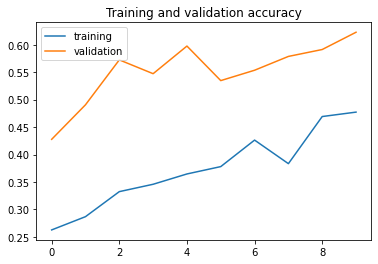

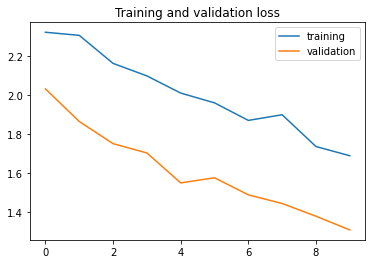

In [27]:
# predictions = model.predict(X_test)
# # predictions = model.predict(test_flow)
# y_pred = np.argmax(predictions, axis=1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [28]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

Now, Let's take a look to confusion matrix.

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

print()

print('Classification Report')
print(classification_report(y_test, 
                            y_pred, 
                            target_names=CATEGORIES))

Confusion Matrix
[[ 0  0  0  0  0  0  0  1  0  2  0  0  9  0  2  0  0  2  4]
 [ 0  3  0  0  1  0  0  1  0  0  0  0 14  0  0  0  0  0  1]
 [ 0  0  0  0  2  0  0  1  0  0  0  0 12  0  1  0  0  0  4]
 [ 0  1  0  0  3  0  0  1  0  0  0  0 12  0  0  0  0  1  2]
 [ 0  2  0  0  3  0  0  1  0  0  0  0 10  0  1  0  0  3  0]
 [ 0  1  0  0  3  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 1  2  0  0  4  1  0  0  0  1  0  0  6  1  0  0  0  4  0]
 [ 0  0  0  0  1  0  0  0  0  2  0  0  7  0  0  0  0  6  4]
 [ 0  0  0  0  2  0  0  0  0  2  0  0 11  0  1  0  0  3  1]
 [ 0  0  0  0  7  0  0  2  0  1  0  0  4  0  0  0  0  4  2]
 [ 1  3  0  0  5  0  0  0  0  1  0  0  5  0  1  0  0  4  0]
 [ 0  1  0  0  4  0  0  0  0  0  0  0  7  0  1  0  0  7  0]
 [ 1  1  0  0  1  0  0  1  0  0  0  0 14  0  0  0  0  1  1]
 [ 0  2  0  0  4  0  0  0  0  0  0  0  7  0  1  0  0  6  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0 12  0  1  0  0  4  0]
 [ 0  4  0  0  2  1  0  0  0  1  0  0 10  1  0  0  0  0  1]
 [ 0  0  0  0  3  2  0 

c:\users\asreno\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\asreno\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\asreno\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now, we can save the model.

In [ ]:
# model.save("DenseNet169.h5")

we can also visualized the accuracy on training and test data.

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, label = "training")
# plt.plot(epochs, val_acc, label = "validation")
# plt.legend(loc="upper left")
# plt.title('Training and validation accuracy')

# plt.figure()

# plt.plot(epochs, loss, label = "training")
# plt.plot(epochs, val_loss, label = "validation")
# plt.legend(loc="upper right")
# plt.title('Training and validation loss')

In [30]:
# loss_val, acc_val = model.evaluate(test_flow, y_test_cat, verbose=1)
loss_and_metrics = model.evaluate(test_flow, verbose=2)
print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

12/12 - 185s - loss: 1.4787 - accuracy: 0.5553
Test Loss 1.4787265062332153
Test Accuracy 0.5552631616592407
